In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import glob

train_files = glob.glob('/content/drive/My Drive/PLH/langId/*_trn.txt')
test_files = glob.glob('/content/drive/My Drive/PLH/langId/*_tst.txt')

In [4]:
import re

def preprocessar_text(text):
    # Eliminar els digits restants en el text
    text = re.sub(r'\d+', '', text)

    # Eliminar els caràcters especials
    text = re.sub(r'[#$%&*%{}[]+', '', text)

    # Convertir tot el text a minúscula
    text = text.lower()

    # Substituir els espais en blanc continus per un únic espai
    text = re.sub(r'\s+', ' ', text).strip()

    # Separar les diferents frases basant-nos en si hi ha un punt seguit d'un espai
    frases = text.split('. ')

    # Eliminar elements buits que podrien aparèixer per la separació
    text = [frase.strip() for frase in frases if frase]

    # Concatenar totes les frases amb un espai doble al mig
    text = '  '.join(text)

    return text

In [5]:
from nltk import ngrams
from collections import Counter

def get_trigrams(text):
    text = '  ' + text + '  '
    trigrams = list(ngrams(text, 3))
    return trigrams

def remove_infreq_trigrams(trigram_counts, threshold=5):
    # Elimina trigrams amb una freqüència menor al llindar
    return {trigram: count for trigram, count in trigram_counts.items() if count >= threshold}

def lid(count, total, lambda_, B):
  # Calcula la probabilitat amb la Llei de Lidstone
  return (count+lambda_)/(total + lambda_*B)

def comptar_caracters_diferents(texto):
  # Compta el nombre de caràcters únics
  return len(set(texto))

def extract_language(file, train = True):
  # Extreu l'idioma del nom del fitxer
  if train:
    return re.search(r'(\w+)_trn\.txt', file).group(1)
  return re.search(r'(\w+)_tst\.txt', file).group(1)

In [6]:
def train_val(text, percentatge=0.7):
    # Comptar el nombre total d'espais dobles en el text
    num_espais_dobles = text.count("  ")

    # Calcular l'índex on es dividirà el text
    index_divisio = int(num_espais_dobles * percentatge)

    # Inicialitzar les variables de text amb valors predeterminats
    text_1 = text
    text_2 = ''

    # Inicialitzar l'índex actual i el nombre d'espais dobles trobats
    index_actual = 0
    espais_dobles_trobats = 0

    # Trobar el punt de divisió
    for i, char in enumerate(text):
        if text[i:i+2] == "  ":  # Verificar si hi ha un espai doble
            espais_dobles_trobats += 1
            if espais_dobles_trobats == index_divisio:
                # Dividir el text en dues parts en aquest punt si trobem l'índex de divisió
                text_1 = text[:i]
                text_2 = text[i:]
                break

    return text_1, text_2


In [7]:
X_train, y_train, X_test, y_test, X_val, y_val = [], [], [], [], [], []

# Processar fitxers d'entrenament
for file in train_files:
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
        text = preprocessar_text(text)
        text_train, text_val = train_val(text) # dividim el text en train/val
        X_train.append(text_train)
        y_train.append(extract_language(file, train = True))
        X_val.append(text_val)
        y_val.append(extract_language(file, train = True))

# Processar fitxers de prova
for file in test_files:
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            X_test.append(preprocessar_text(line))
            y_test.append(extract_language(file, train = False))



In [8]:
# Diccionari per comptar els trigrams de cada idioma
trigram_counts = {lang: {} for lang in y_train}
for text in X_train:
    language = y_train[X_train.index(text)]
    trigram_counts[language] = get_trigrams(text)
    trigram_counts[language] = Counter(trigram_counts[language])

    remove_infreq_trigrams(trigram_counts[language])

In [9]:
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evaluate(X, y, lambda_, B, conf_matrix=False):
    languages = set(y_train)

    # Diccionari per emmagatzemar la matriu de confusió
    conf_matrix_dict = {lang: {lang_pred: 0 for lang_pred in languages} for lang in languages}

    # Inicialitzar comptadors per a les prediccions totals i correcte
    total_predictions = 0
    correct_predictions = 0

    for text, true_lang in zip(X, y):
        trigramas_texto = get_trigrams(text)
        pred_lang = None
        max_prob = float('-inf')

        for lang in languages:
            prob_lang = 0

            # Calcular la probabilitat de l'idioma a partir de la freqüència dels trigrames
            for tri in trigramas_texto:
                #calculem la probabilitat amb LID
                prob_lang += math.log(lid(count=trigram_counts[lang].get(tri, 0), total=len(trigram_counts[lang]), lambda_=lambda_, B=B))

            if prob_lang > max_prob:
                max_prob = prob_lang
                pred_lang = lang

        conf_matrix_dict[true_lang][pred_lang] += 1
        total_predictions += 1
        if true_lang == pred_lang:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions

    #Fem la matriu de confusió
    if conf_matrix:
        conf_matrix_df = pd.DataFrame(conf_matrix_dict)
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title('Matriu de Confusió')
        ax.set_xlabel('Idioma Predit')
        ax.set_ylabel('Idioma Real')
        plt.show()

    return accuracy


In [10]:
# Calcula la mitjana de trigrames únics entre els conjunts d'entrenament i prova
def mitjana_trigrames():
  total = 0
  for i in range(len(train_files)):
      with open(train_files[i], 'r', encoding='utf-8') as f:
          text = f.read()
          text = preprocessar_text(text)
          trigrams = set(get_trigrams(text))

      with open(test_files[i], 'r', encoding='utf-8') as f:
          text2 = f.read()
          text2 = preprocessar_text(text2)
          trigrams2 = set(get_trigrams(text2))

      # Unir els trigrams de train i test
      trigrams.update(trigrams2)
      total += len(trigrams)

  return total / len(train_files)


In [11]:
from collections import Counter

# Elimina caràcters infreqüents del text
def eliminar_caracters_poc_comuns(text):

    llindar = len(text)/1000   #0,1% d'aparicions mínim

    comptador_caracters = Counter(text)

    # Seleccionem només aquells caràcters que superen el llindar d'aparició
    caracters_comuns = {caracter for caracter, comptador in comptador_caracters.items() if comptador >= llindar}

    text_filtrat = ''.join(caracter for caracter in text if caracter in caracters_comuns)

    caracters_diferents = comptar_caracters_diferents(text_filtrat)
    return caracters_diferents


In [12]:
total = 0
for text in X_train:
  total  += eliminar_caracters_poc_comuns(text)

mitjana_caracters = total/len(X_train)
mitjana_caracters  = (mitjana_caracters*mitjana_caracters*mitjana_caracters) #elevar a 3
print(mitjana_caracters)


30762.37037037037


In [13]:
mitjana = mitjana_trigrames()
mitjana = mitjana

**ATENCIÓ!!!**

La següent cel·la tarda bastant ja que evalua cada combinació d'hiperparàmetres. Si no voleu executar-la podeu descomentar la línia d'abaix:   
*best_params{'lambda_': 0.1,  'B': 19974.8333333}*

In [32]:
#best_params={'lambda_': 0.1, 'B': 19974.8333333}

In [15]:
valor_mig = (mitjana+mitjana_caracters)/2
param_grid = {
    'lambda_': [0.1, 0.5, 1.0],
    'B': [mitjana, valor_mig, mitjana_caracters], #Provem les 3 B que hem calculat abans
}

best_accuracy = 0
best_params = None

for lambda_ in param_grid['lambda_']:
    for B in param_grid['B']:
        accuracy = evaluate(X_val, y_val, lambda_, B) #probem els parametres amb les dades de validacio
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'lambda_': lambda_, 'B': B}

print("Millors parametres:",best_params)

Millors parametres: {'lambda_': 0.1, 'B': 19974.833333333332}


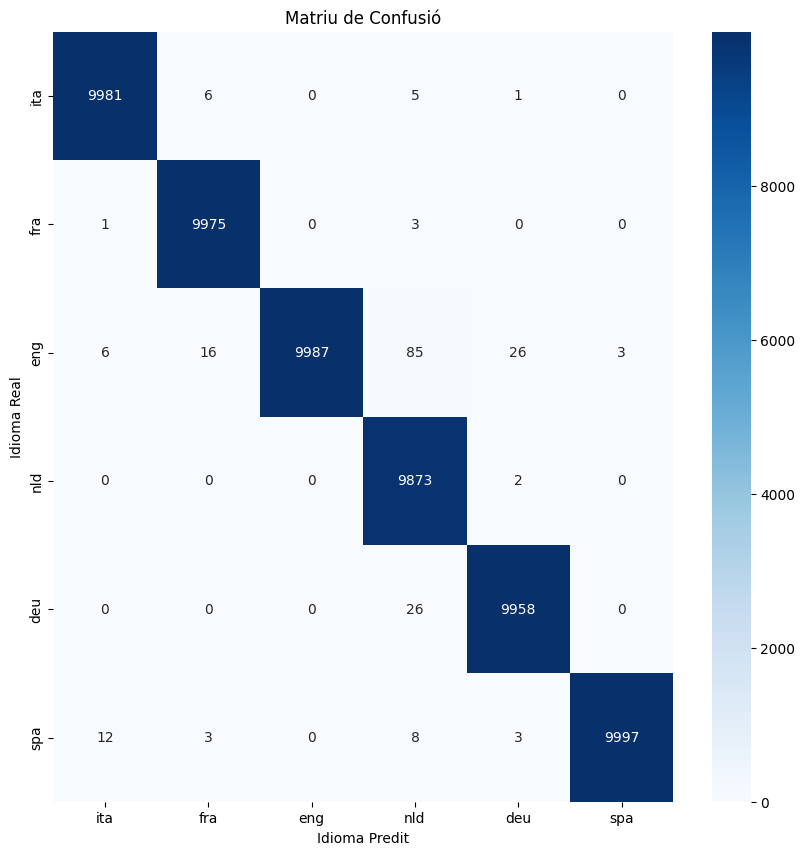

0.9965653500508528

In [33]:
evaluate(X_test, y_test, best_params['lambda_'], best_params['B'], conf_matrix=True)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **PLAYTIME**
### En aquesta cel·la de codi tu mateix pots escriure el text que vulguis en l'idioma que vulguis i et retornarà en quin idioma està escrit el text

In [31]:
import math

texto = "Mijn naam is Luke" #CANVIAR EL TEXT PER PROVAR EL MODEL




trigrama = get_trigrams(texto)

max_prob = float('-inf')
language_max_prob = None

for lang in y_train:
    prob_lang = 0  #Probabilitat del llenguatge actual es 0
    for tri in trigrama:
        prob_lang += math.log(lid(count=trigram_counts[lang].get(tri, 0), total=len(trigram_counts[lang]), lambda_=best_params['lambda_'], B=best_params['B']))


    # Si la probabilitat actual es més gran que la màxima registrada, actualitza els valors
    if prob_lang > max_prob:
        max_prob = prob_lang
        language_max_prob = lang

idiomas = {
    'spa': 'español',
    'ita': 'italiano',
    'fra': 'francés',
    'eng': 'inglés',
    'nld': 'neerlandés',
    'deu': 'alemán'
}
print(f"El idioma del texto que has introducido es: {idiomas[language_max_prob]}")

El idioma del texto que has introducido es: neerlandés
